## X-Ray Abnormality Detection | CNN

> **Antonopoulos Ilias** ( *p3352004* ) <br />
> **Ndoja Silva** ( *p3352017* ) <br />
> **MSc in Data Science, AUEB**

## Table of Contents

- [Data Loading](#Data-Loading)
 * [Create a tensorflow input pipeline for the training data](#Create-a-tensorflow-input-pipeline-for-the-training-data)
 * [Create a tensorflow input pipeline for the testing data](#Create-a-tensorflow-input-pipeline-for-the-testing-data)
- [Baseline Performance](#Baseline-Performance)
 * [Random Classification](#Random-Classification)
 * [CNN architecture with sensible defaults](#CNN-architecture-with-sensible-defaults)
 * [Only on XR_SHOULDER study type](#Only-on-XR_SHOULDER-study-type)

In [1]:
import gc
import os
import pathlib
import random
import re
from glob import glob
from PIL import Image
from typing import Iterable

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_addons as tfa
from matplotlib import image
from sklearn.metrics import cohen_kappa_score, confusion_matrix


pd.set_option("max_colwidth", None)
plt.style.use("dark_background")

In [2]:
print(tf.__version__)

2.8.0


In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices("GPU")))

Num GPUs Available:  1


2022-03-31 14:00:29.044949: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-31 14:00:29.073023: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-31 14:00:29.073328: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [4]:
gpus = tf.config.experimental.list_physical_devices("GPU")

try:
    tf.config.experimental.set_memory_growth(gpus[0], True)
except IndexError:
    print("Cannot memory-restrict the GPU, if no GPU exists in system. Ignore...")
    pass

In [5]:
SEED = 99910123

os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)
np.random.seed(SEED)

### Data Loading

In [6]:
DATASET_DIR = "../data/MURA-v1.1/"

In [7]:
def inspect_df(df: pd.DataFrame, n: int = 5) -> pd.DataFrame:
    """Helper method to easily inspect DataFrames."""

    print(f"shape: {df.shape}")

    return df.head(n)

In [8]:
random.choices(glob(os.path.join(DATASET_DIR, "*", "*", "*", "*", "*.png")), k=10)

['../data/MURA-v1.1/train/XR_WRIST/patient08092/study1_negative/image1.png',
 '../data/MURA-v1.1/train/XR_FINGER/patient01064/study1_positive/image1.png',
 '../data/MURA-v1.1/valid/XR_ELBOW/patient11831/study1_positive/image1.png',
 '../data/MURA-v1.1/train/XR_SHOULDER/patient00442/study1_positive/image1.png',
 '../data/MURA-v1.1/train/XR_ELBOW/patient06289/study1_negative/image3.png',
 '../data/MURA-v1.1/train/XR_WRIST/patient08562/study1_negative/image2.png',
 '../data/MURA-v1.1/train/XR_FINGER/patient04280/study1_negative/image3.png',
 '../data/MURA-v1.1/train/XR_WRIST/patient07018/study1_positive/image1.png',
 '../data/MURA-v1.1/train/XR_ELBOW/patient06000/study1_negative/image1.png',
 '../data/MURA-v1.1/train/XR_SHOULDER/patient00497/study2_negative/image4.png']

So, the data structure is the following:

```

└─train {data subset}
│   └───XR_ELBOW {study type}
│       │  └───patient00011 {patient}
│       │         └───study1_negative {study with label}
│       │               └───image1.png {view}
│       │               └───image2.png 
│       │               └───image3.png 
                        └───...
   ...
   

└─valid {data subset}
│   └───XR_HUMERUS {study type}
│       │  └───patient11216 {patient}
│       │         └───study1_negative {study with label}
│       │               └───image1.png {view}
│       │               └───image2.png 
                        └───...
```

In [9]:
image_count = len(list(pathlib.Path(DATASET_DIR).glob("*/*/*/*/*.png")))

print(f"Total PNG images found in dir <{DATASET_DIR}>: {image_count}")

Total PNG images found in dir <../data/MURA-v1.1/>: 40009


We will start by creating a tabular form of the training data (with no actual image files), in order to quickly analyze them. A proper data loader (of the actual image files) will be implemented after that, in a tensorflow-friendly manner.

In [10]:
train_image_paths = pd.read_csv(
    os.path.join(DATASET_DIR, "train_image_paths.csv"),
    names=["image_path"],
    header=None,
    index_col=False,
)

inspect_df(train_image_paths)

shape: (36808, 1)


,image_path
0,MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image1.png
1,MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image2.png
2,MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image3.png
3,MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/image1.png
4,MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/image2.png


In [11]:
train_image_paths["image_path"] = train_image_paths["image_path"].map(
    lambda x: os.path.join("../data/", x)
)
train_image_paths["study_type"] = train_image_paths["image_path"].map(
    lambda x: x.split("/")[4]
)
train_image_paths["patient"] = train_image_paths["image_path"].map(
    lambda x: x.split("/")[5]
)
train_image_paths["study"] = train_image_paths["image_path"].map(
    lambda x: x.split("/")[6]
)
train_image_paths["study_path"] = train_image_paths["image_path"].map(
    lambda x: re.sub(r"image\d+.png", "", x)
)

In [12]:
inspect_df(train_image_paths)

shape: (36808, 5)


,image_path,study_type,patient,study,study_path
0,../data/MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image1.png,XR_SHOULDER,patient00001,study1_positive,../data/MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/
1,../data/MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image2.png,XR_SHOULDER,patient00001,study1_positive,../data/MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/
2,../data/MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image3.png,XR_SHOULDER,patient00001,study1_positive,../data/MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/
3,../data/MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/image1.png,XR_SHOULDER,patient00002,study1_positive,../data/MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/
4,../data/MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/image2.png,XR_SHOULDER,patient00002,study1_positive,../data/MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/


In [13]:
train_labeled_studies = pd.read_csv(
    os.path.join(DATASET_DIR, "train_labeled_studies.csv"),
    names=["study_path", "label"],
    header=None,
    index_col=False,
)

inspect_df(train_labeled_studies)

shape: (13457, 2)


,study_path,label
0,MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/,1
1,MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/,1
2,MURA-v1.1/train/XR_SHOULDER/patient00003/study1_positive/,1
3,MURA-v1.1/train/XR_SHOULDER/patient00004/study1_positive/,1
4,MURA-v1.1/train/XR_SHOULDER/patient00005/study1_positive/,1


In [14]:
train_labeled_studies["study_path"] = train_labeled_studies["study_path"].map(
    lambda x: os.path.join("../data/", x)
)
train_labeled_studies["label"] = train_labeled_studies["label"].map(str)

In [15]:
inspect_df(train_labeled_studies)

shape: (13457, 2)


,study_path,label
0,../data/MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/,1
1,../data/MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/,1
2,../data/MURA-v1.1/train/XR_SHOULDER/patient00003/study1_positive/,1
3,../data/MURA-v1.1/train/XR_SHOULDER/patient00004/study1_positive/,1
4,../data/MURA-v1.1/train/XR_SHOULDER/patient00005/study1_positive/,1


In [16]:
ref_trainset = pd.merge(
    train_image_paths, train_labeled_studies, how="inner", on="study_path"
)

inspect_df(ref_trainset)

shape: (36808, 6)


,image_path,study_type,patient,study,study_path,label
0,../data/MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image1.png,XR_SHOULDER,patient00001,study1_positive,../data/MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/,1
1,../data/MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image2.png,XR_SHOULDER,patient00001,study1_positive,../data/MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/,1
2,../data/MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image3.png,XR_SHOULDER,patient00001,study1_positive,../data/MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/,1
3,../data/MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/image1.png,XR_SHOULDER,patient00002,study1_positive,../data/MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/,1
4,../data/MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/image2.png,XR_SHOULDER,patient00002,study1_positive,../data/MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/,1


#### Create a tensorflow input pipeline for the training data

In [17]:
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224

In [18]:
training = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1.0 / 255,
    validation_split=0.2,
)

In [19]:
trainset = training.flow_from_dataframe(
    dataframe=ref_trainset,
    x_col="image_path",
    y_col="label",
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode="binary",
    batch_size=32,
    seed=SEED,
    shuffle=True,
    subset="training",
)

Found 29447 validated image filenames belonging to 2 classes.


In [20]:
validationset = training.flow_from_dataframe(
    dataframe=ref_trainset,
    x_col="image_path",
    y_col="label",
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode="binary",
    batch_size=32,
    seed=SEED,
    shuffle=False,
    subset="validation",
)

Found 7361 validated image filenames belonging to 2 classes.


#### Create a tensorflow input pipeline for the testing data

In [21]:
test_image_paths = pd.read_csv(
    os.path.join(DATASET_DIR, "valid_image_paths.csv"),
    names=["image_path"],
    header=None,
    index_col=False,
)

In [22]:
test_image_paths["image_path"] = test_image_paths["image_path"].map(
    lambda x: os.path.join("../data/", x)
)
test_image_paths["study_type"] = test_image_paths["image_path"].map(
    lambda x: x.split("/")[4]
)
test_image_paths["patient"] = test_image_paths["image_path"].map(
    lambda x: x.split("/")[5]
)
test_image_paths["study"] = test_image_paths["image_path"].map(
    lambda x: x.split("/")[6]
)
test_image_paths["study_path"] = test_image_paths["image_path"].map(
    lambda x: re.sub(r"image\d+.png", "", x)
)

In [23]:
test_labeled_studies = pd.read_csv(
    os.path.join(DATASET_DIR, "valid_labeled_studies.csv"),
    names=["study_path", "label"],
    header=None,
    index_col=False,
)

In [24]:
test_labeled_studies["study_path"] = test_labeled_studies["study_path"].map(
    lambda x: os.path.join("../data/", x)
)
test_labeled_studies["label"] = test_labeled_studies["label"].map(str)

In [25]:
ref_testset = pd.merge(
    test_image_paths, test_labeled_studies, how="inner", on="study_path"
)

inspect_df(ref_testset)

shape: (3197, 6)


,image_path,study_type,patient,study,study_path,label
0,../data/MURA-v1.1/valid/XR_WRIST/patient11185/study1_positive/image1.png,XR_WRIST,patient11185,study1_positive,../data/MURA-v1.1/valid/XR_WRIST/patient11185/study1_positive/,1
1,../data/MURA-v1.1/valid/XR_WRIST/patient11185/study1_positive/image2.png,XR_WRIST,patient11185,study1_positive,../data/MURA-v1.1/valid/XR_WRIST/patient11185/study1_positive/,1
2,../data/MURA-v1.1/valid/XR_WRIST/patient11185/study1_positive/image3.png,XR_WRIST,patient11185,study1_positive,../data/MURA-v1.1/valid/XR_WRIST/patient11185/study1_positive/,1
3,../data/MURA-v1.1/valid/XR_WRIST/patient11185/study1_positive/image4.png,XR_WRIST,patient11185,study1_positive,../data/MURA-v1.1/valid/XR_WRIST/patient11185/study1_positive/,1
4,../data/MURA-v1.1/valid/XR_WRIST/patient11186/study1_positive/image1.png,XR_WRIST,patient11186,study1_positive,../data/MURA-v1.1/valid/XR_WRIST/patient11186/study1_positive/,1


In [26]:
testing = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1.0 / 255,
)

In [27]:
testset = testing.flow_from_dataframe(
    dataframe=ref_testset,
    x_col="image_path",
    y_col="label",
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode="binary",
    batch_size=32,
    seed=SEED,
    shuffle=False,  # this is very important in order to properly use raw predictions to evaluate on study-level!
)

Found 3197 validated image filenames belonging to 2 classes.


### Baseline Performance

#### Random Classification

In [28]:
class RandomClassifier(object):
    """Random classifier - predicts whether an image is normal or abnormal at random."""

    def predict(self, image_path: str) -> float:

        return random.random()

In [29]:
temp_testset = ref_testset.copy()

temp_testset["label"] = temp_testset["label"].map(int)

In [30]:
model = RandomClassifier()

temp_testset["prediction"] = temp_testset["image_path"].map(model.predict)

In [31]:
cohen_kappa_score(
    temp_testset["label"].values,
    np.vectorize(lambda x: 1 if x > 0.5 else 0)(temp_testset["prediction"].values),
)

0.0049013669964691475

We now have to aggregate all the predictions - in a meaningful way - at the study level.

We will assume that if the majority of the images of a given study are classified as abnormal, then the study will be classified as abnormal as well (and vice versa).

In [32]:
def study_oriented_transformation(dataset: pd.DataFrame) -> Iterable:

    for study, group in dataset.groupby("study_path"):

        study_label = group["label"].values.take(0)
        study_prediction = 1 if group["prediction"].mean() > 0.5 else 0

        yield study, study_label, study_prediction

In [33]:
temp_testset = pd.DataFrame(
    [*study_oriented_transformation(temp_testset)],
    columns=["study", "label", "prediction"],
)

In [34]:
cohen_kappa_score(temp_testset["label"].values, temp_testset["prediction"].values)

-0.02330674545107736

In [35]:
del temp_testset
del model

#### CNN architecture with sensible defaults

In [36]:
def clean_up(model_):
    tf.keras.backend.clear_session()
    del model_
    gc.collect()

In [37]:
# the tfa.metrics.F1Score (https://www.tensorflow.org/addons/api_docs/python/tfa/metrics/F1Score)
# requires some reshaping that is inconsistent with the other metrics we like to track
# so we will define it from scratch


class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name="f1_score", **kwargs):
        super().__init__(name=name, **kwargs)
        self.f1 = self.add_weight(name="f1", initializer="zeros")
        self.precision_fn = tf.keras.metrics.Precision()
        self.recall_fn = tf.keras.metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        p = self.precision_fn(y_true, y_pred)
        r = self.recall_fn(y_true, y_pred)
        self.f1.assign(2 * ((p * r) / (p + r + 1e-10)))

    def result(self):
        return self.f1

    def reset_state(self):
        # we also need to reset the state of the precision and recall objects
        self.precision_fn.reset_state()
        self.recall_fn.reset_state()
        self.f1.assign(0)

In [38]:
METRICS = [
    tf.keras.metrics.TruePositives(name="tp"),
    tf.keras.metrics.FalsePositives(name="fp"),
    tf.keras.metrics.TrueNegatives(name="tn"),
    tf.keras.metrics.FalseNegatives(name="fn"),
    tf.keras.metrics.BinaryAccuracy(name="binary_acc"),
    tf.keras.metrics.Precision(name="precision"),
    tf.keras.metrics.Recall(name="recall"),
    F1Score(name="f1_score"),
    tf.keras.metrics.AUC(name="roc_auc", curve="ROC"),
    tf.keras.metrics.AUC(name="pr_auc", curve="PR"),
    tfa.metrics.CohenKappa(name="cohen_kappa", num_classes=2),
]

2022-03-31 14:00:30.728016: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-31 14:00:30.730152: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-31 14:00:30.730356: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-31 14:00:30.730474: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [39]:
def plot_metrics(
    history: tf.keras.callbacks.History,
    metrics: list = ["loss", "cohen_kappa", "precision", "recall"],
) -> None:

    plt.rcParams["figure.figsize"] = (18, 15)

    for n, metric in enumerate(metrics):
        name = metric.replace("_", " ").capitalize()
        plt.subplot(2, 2, n + 1)
        plt.plot(
            history.epoch, history.history[metric], linewidth=1.8, label="training"
        )
        plt.plot(
            history.epoch,
            history.history["val_" + metric],
            linestyle="--",
            linewidth=1.8,
            label="validation",
        )
        plt.xlabel("epoch")
        plt.ylabel(name)
        if metric == "loss":
            plt.ylim([0, plt.ylim()[1]])
        elif metric == "cohen_kappa":
            plt.ylim([-1, 1])
        else:
            plt.ylim([0, 1])

        plt.legend()

In [40]:
def make_cnn_model():
    """Creates a CNN architecture with sensible defaults."""
    model = tf.keras.Sequential(
        [
            tf.keras.layers.Conv2D(
                filters=32,
                kernel_size=(3, 3),
                strides=(1, 1),
                padding="same",
                kernel_regularizer="l2",
                dilation_rate=(1, 1),
                activation="relu",
                input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3),
                name="1st-convolution",
            ),
            tf.keras.layers.BatchNormalization(name="1st-batch-norm"),
            tf.keras.layers.MaxPool2D(
                pool_size=(2, 2), strides=(2, 2), padding="same", name="1st-max-pooling"
            ),
            tf.keras.layers.Dropout(
                rate=0.15,
                name="1st-dropout",
            ),
            tf.keras.layers.Conv2D(
                filters=64,
                kernel_size=(3, 3),
                strides=(1, 1),
                padding="same",
                kernel_regularizer="l2",
                dilation_rate=(1, 1),
                activation="relu",
                name="2nd-convolution",
            ),
            tf.keras.layers.BatchNormalization(name="2nd-batch-norm"),
            tf.keras.layers.MaxPool2D(
                pool_size=(2, 2), strides=(2, 2), padding="same", name="2nd-max-pooling"
            ),
            tf.keras.layers.Dropout(
                rate=0.15,
                name="2nd-dropout",
            ),
            tf.keras.layers.Conv2D(
                filters=128,
                kernel_size=(3, 3),
                strides=(1, 1),
                padding="same",
                kernel_regularizer="l2",
                dilation_rate=(1, 1),
                activation="relu",
                name="3rd-convolution",
            ),
            tf.keras.layers.BatchNormalization(name="3rd-batch-norm"),
            tf.keras.layers.MaxPool2D(
                pool_size=(2, 2), strides=(2, 2), padding="same", name="3rd-max-pooling"
            ),
            tf.keras.layers.Dropout(
                rate=0.15,
                name="3rd-dropout",
            ),
            tf.keras.layers.Flatten(name="flatten-layer"),
            tf.keras.layers.Dense(
                units=32,
                kernel_regularizer="l2",
                activation="relu",
                name="dense-layer",
            ),
            tf.keras.layers.Dense(units=1, activation="sigmoid", name="output-layer"),
        ]
    )

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=METRICS,
    )

    return model

In [41]:
model = make_cnn_model()

In [42]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 1st-convolution (Conv2D)    (None, 224, 224, 32)      896       
                                                                 
 1st-batch-norm (BatchNormal  (None, 224, 224, 32)     128       
 ization)                                                        
                                                                 
 1st-max-pooling (MaxPooling  (None, 112, 112, 32)     0         
 2D)                                                             
                                                                 
 1st-dropout (Dropout)       (None, 112, 112, 32)      0         
                                                                 
 2nd-convolution (Conv2D)    (None, 112, 112, 64)      18496     
                                                                 
 2nd-batch-norm (BatchNormal  (None, 112, 112, 64)     2

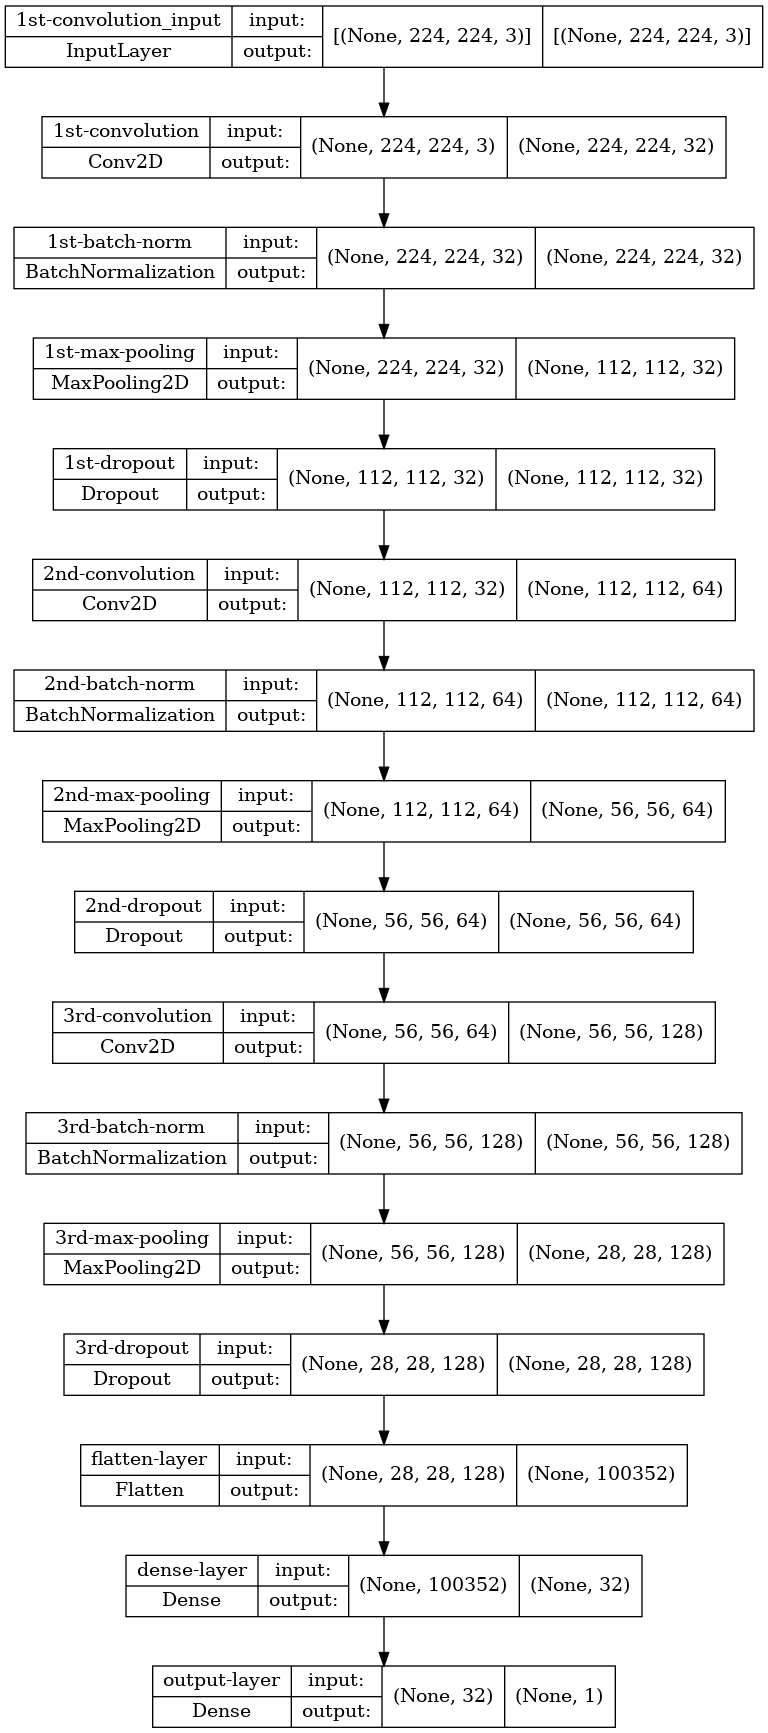

In [43]:
tf.keras.utils.plot_model(
    model,
    to_file="../static/cnn-all-study-types-3305473.png",
    show_shapes=True,
    show_layer_names=True,
)

In [44]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    mode="min",
    verbose=1,
    patience=20,
)

In [45]:
reduce_lr_on_plateau = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss", mode="min", factor=0.2, verbose=1, patience=5, min_lr=1e-6
)

In [46]:
history = model.fit(
    trainset,
    epochs=100,
    validation_data=validationset,
    callbacks=[early_stopping, reduce_lr_on_plateau],
)

Epoch 1/100


2022-03-31 14:00:35.209846: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8303


921/921 [==============================] - 180s 189ms/step - loss: 1.9228 - tp: 266.0000 - fp: 320.0000 - tn: 18422.0000 - fn: 10439.0000 - binary_acc: 0.6346 - precision: 0.4539 - recall: 0.0248 - f1_score: 0.0471 - roc_auc: 0.5581 - pr_auc: 0.3951 - cohen_kappa: 0.0098 - val_loss: 1.4399 - val_tp: 279.0000 - val_fp: 198.0000 - val_tn: 2995.0000 - val_fn: 3889.0000 - val_binary_acc: 0.4448 - val_precision: 0.5849 - val_recall: 0.0669 - val_f1_score: 0.1201 - val_roc_auc: 0.5123 - val_pr_auc: 0.5799 - val_cohen_kappa: 0.0043 - lr: 1.0000e-04
Epoch 2/100
921/921 [==============================] - 175s 190ms/step - loss: 1.0257 - tp: 41.0000 - fp: 65.0000 - tn: 18677.0000 - fn: 10664.0000 - binary_acc: 0.6357 - precision: 0.3868 - recall: 0.0038 - f1_score: 0.0076 - roc_auc: 0.6627 - pr_auc: 0.4929 - cohen_kappa: 4.5937e-04 - val_loss: 1.0950 - val_tp: 3.0000 - val_fp: 6.0000 - val_tn: 3187.0000 - val_fn: 4165.0000 - val_binary_acc: 0.4334 - val_precision: 0.3333 - val_recall: 7.1977e-04

921/921 [==============================] - 178s 193ms/step - loss: 0.3716 - tp: 8766.0000 - fp: 788.0000 - tn: 17954.0000 - fn: 1939.0000 - binary_acc: 0.9074 - precision: 0.9175 - recall: 0.8189 - f1_score: 0.8654 - roc_auc: 0.9681 - pr_auc: 0.9508 - cohen_kappa: 0.7952 - val_loss: 2.0677 - val_tp: 206.0000 - val_fp: 66.0000 - val_tn: 3127.0000 - val_fn: 3962.0000 - val_binary_acc: 0.4528 - val_precision: 0.7574 - val_recall: 0.0494 - val_f1_score: 0.0928 - val_roc_auc: 0.5747 - val_pr_auc: 0.6372 - val_cohen_kappa: 0.0252 - lr: 4.0000e-06
Epoch 15/100
921/921 [==============================] - 180s 195ms/step - loss: 0.3588 - tp: 8892.0000 - fp: 706.0000 - tn: 18036.0000 - fn: 1813.0000 - binary_acc: 0.9145 - precision: 0.9264 - recall: 0.8306 - f1_score: 0.8759 - roc_auc: 0.9724 - pr_auc: 0.9572 - cohen_kappa: 0.8110 - val_loss: 2.1727 - val_tp: 207.0000 - val_fp: 59.0000 - val_tn: 3134.0000 - val_fn: 3961.0000 - val_binary_acc: 0.4539 - val_precision: 0.7782 - val_recall: 0.0497 - 

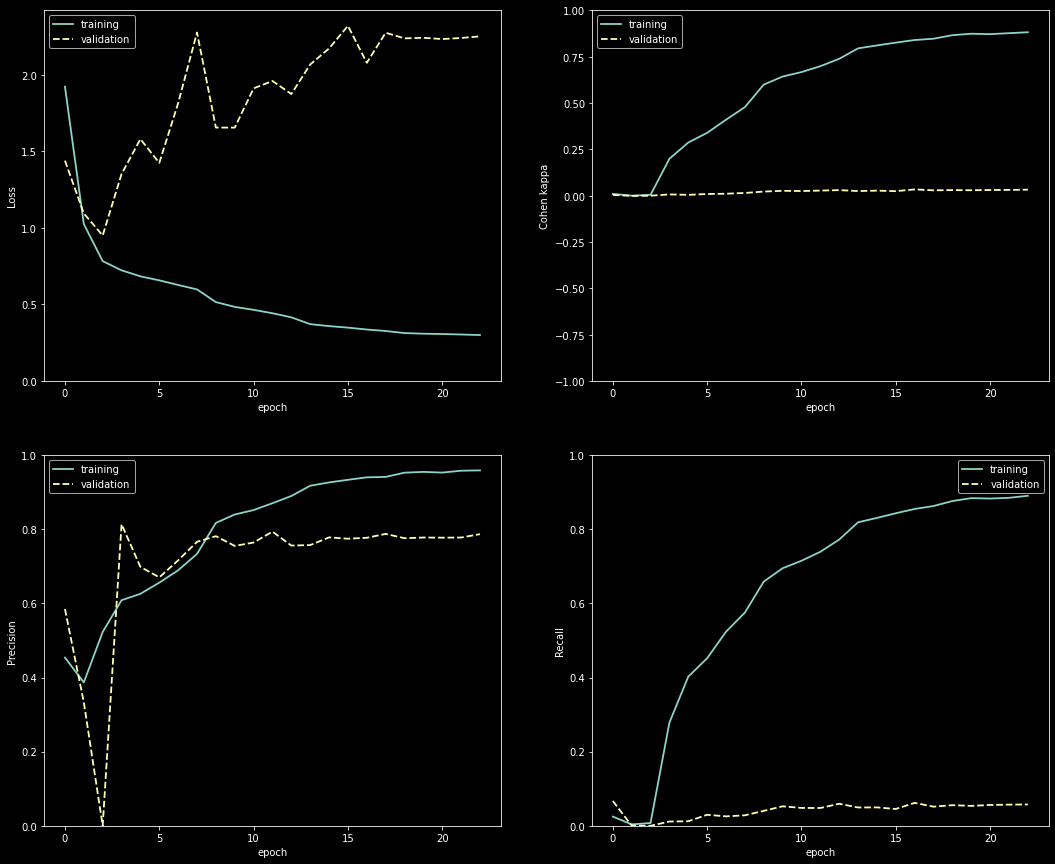

In [47]:
plot_metrics(history)

In [48]:
# get the loss value & metrics values for the model in test mode
evaluation_metrics = model.evaluate(testset, verbose=1)

100/100 [==============================] - 11s 112ms/step - loss: 1.0607 - tp: 599.0000 - fp: 157.0000 - tn: 1510.0000 - fn: 931.0000 - binary_acc: 0.6597 - precision: 0.7923 - recall: 0.3915 - f1_score: 0.5241 - roc_auc: 0.7192 - pr_auc: 0.7361 - cohen_kappa: 0.3036


In [49]:
loss = evaluation_metrics.pop(0)

print(f"test loss   : {loss}")
for metric, score in zip(METRICS, evaluation_metrics):

    print(f"{metric.name + ' ' * (12 - len(metric.name))}: {score}")

test loss   : 1.0606653690338135
tp          : 599.0
fp          : 157.0
tn          : 1510.0
fn          : 931.0
binary_acc  : 0.659680962562561
precision   : 0.7923280596733093
recall      : 0.3915032744407654
f1_score    : 0.5240594744682312
roc_auc     : 0.7192187309265137
pr_auc      : 0.7360536456108093
cohen_kappa : 0.30363398790359497


In [50]:
# get predictions for the test dataset
preds = model.predict(testset, verbose=1)

100/100 [==============================] - 10s 100ms/step


In [51]:
temp_testset = ref_testset.copy()

temp_testset["label"] = temp_testset["label"].map(int)

In [52]:
cohen_kappa_score(
    temp_testset["label"].values,
    np.vectorize(lambda x: 1 if x > 0.5 else 0)(preds.ravel()),
)

0.3036339270091464

In [53]:
temp_testset["prediction"] = preds.ravel()

In [54]:
temp_testset = pd.DataFrame(
    [*study_oriented_transformation(temp_testset)],
    columns=["study", "label", "prediction"],
)

In [55]:
cohen_kappa_score(temp_testset["label"].values, temp_testset["prediction"].values)

0.33004350049280795

In [56]:
# model naming convention: {architecture}-{study-type}-{num-parameters}.h5
#
# to load model:
# model = tf.keras.models.load_model(
#     '../models/cnn-all-study-types-3305473.h5',
#     custom_objects={'F1Score': F1Score}
# )
model.save("../models/cnn-all-study-types-3305473.h5")

In [57]:
clean_up(model)
del temp_testset

#### Only on XR_SHOULDER study type

In [74]:
trainset = training.flow_from_dataframe(
    dataframe=ref_trainset[ref_trainset["study_type"] == "XR_SHOULDER"],
    x_col="image_path",
    y_col="label",
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode="binary",
    batch_size=32,
    seed=SEED,
    shuffle=True,
    subset="training",
)

Found 6704 validated image filenames belonging to 2 classes.


In [75]:
validationset = training.flow_from_dataframe(
    dataframe=ref_trainset[ref_trainset["study_type"] == "XR_SHOULDER"],
    x_col="image_path",
    y_col="label",
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode="binary",
    batch_size=32,
    seed=SEED,
    shuffle=False,
    subset="validation",
)

Found 1675 validated image filenames belonging to 2 classes.


In [76]:
testset = testing.flow_from_dataframe(
    dataframe=ref_testset[ref_testset["study_type"] == "XR_SHOULDER"],
    x_col="image_path",
    y_col="label",
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode="binary",
    batch_size=32,
    shuffle=False,  # this is very important in order to properly use raw predictions to evaluate on study-level!
    seed=SEED,
)

Found 563 validated image filenames belonging to 2 classes.


In [77]:
model = make_cnn_model()

In [78]:
history = model.fit(
    trainset,
    epochs=100,
    validation_data=validationset,
    callbacks=[early_stopping, reduce_lr_on_plateau],
)

Epoch 1/100
210/210 [==============================] - 40s 181ms/step - loss: 2.5243 - tp: 406.0000 - fp: 377.0000 - tn: 4047.0000 - fn: 2437.0000 - binary_acc: 0.6128 - precision: 0.5185 - recall: 0.1428 - f1_score: 0.2239 - roc_auc: 0.5585 - pr_auc: 0.4591 - cohen_kappa: 0.0662 - val_loss: 15.5182 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 72.0000 - val_fn: 1603.0000 - val_binary_acc: 0.0430 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00 - val_roc_auc: 0.5000 - val_pr_auc: 0.9570 - val_cohen_kappa: 0.0000e+00 - lr: 1.0000e-04
Epoch 2/100
210/210 [==============================] - 36s 172ms/step - loss: 2.0795 - tp: 562.0000 - fp: 491.0000 - tn: 3648.0000 - fn: 2003.0000 - binary_acc: 0.6280 - precision: 0.5337 - recall: 0.2191 - f1_score: 0.3107 - roc_auc: 0.6107 - pr_auc: 0.4858 - cohen_kappa: 0.1132 - val_loss: 5.1594 - val_tp: 4.0000 - val_fp: 0.0000e+00 - val_tn: 72.0000 - val_fn: 1599.0000 - val_binary_acc: 0.0454 - val_precision: 1.0000

Epoch 16/100
210/210 [==============================] - 42s 198ms/step - loss: 0.5021 - tp: 2419.0000 - fp: 73.0000 - tn: 4066.0000 - fn: 146.0000 - binary_acc: 0.9673 - precision: 0.9707 - recall: 0.9431 - f1_score: 0.9567 - roc_auc: 0.9953 - pr_auc: 0.9929 - cohen_kappa: 0.9305 - val_loss: 1.6245 - val_tp: 760.0000 - val_fp: 8.0000 - val_tn: 64.0000 - val_fn: 843.0000 - val_binary_acc: 0.4919 - val_precision: 0.9896 - val_recall: 0.4741 - val_f1_score: 0.6411 - val_roc_auc: 0.7117 - val_pr_auc: 0.9825 - val_cohen_kappa: 0.0555 - lr: 2.0000e-05
Epoch 17/100
210/210 [==============================] - 42s 199ms/step - loss: 0.4772 - tp: 2446.0000 - fp: 48.0000 - tn: 4091.0000 - fn: 119.0000 - binary_acc: 0.9751 - precision: 0.9808 - recall: 0.9536 - f1_score: 0.9670 - roc_auc: 0.9969 - pr_auc: 0.9949 - cohen_kappa: 0.9470 - val_loss: 1.4663 - val_tp: 875.0000 - val_fp: 15.0000 - val_tn: 57.0000 - val_fn: 728.0000 - val_binary_acc: 0.5564 - val_precision: 0.9831 - val_recall: 0.5459 - va

Epoch 30/100
210/210 [==============================] - 41s 194ms/step - loss: 0.3885 - tp: 2530.0000 - fp: 9.0000 - tn: 4130.0000 - fn: 35.0000 - binary_acc: 0.9934 - precision: 0.9965 - recall: 0.9864 - f1_score: 0.9914 - roc_auc: 0.9997 - pr_auc: 0.9995 - cohen_kappa: 0.9861 - val_loss: 1.5590 - val_tp: 864.0000 - val_fp: 16.0000 - val_tn: 56.0000 - val_fn: 739.0000 - val_binary_acc: 0.5493 - val_precision: 0.9818 - val_recall: 0.5390 - val_f1_score: 0.6959 - val_roc_auc: 0.7147 - val_pr_auc: 0.9825 - val_cohen_kappa: 0.0547 - lr: 1.0000e-06
Epoch 30: early stopping


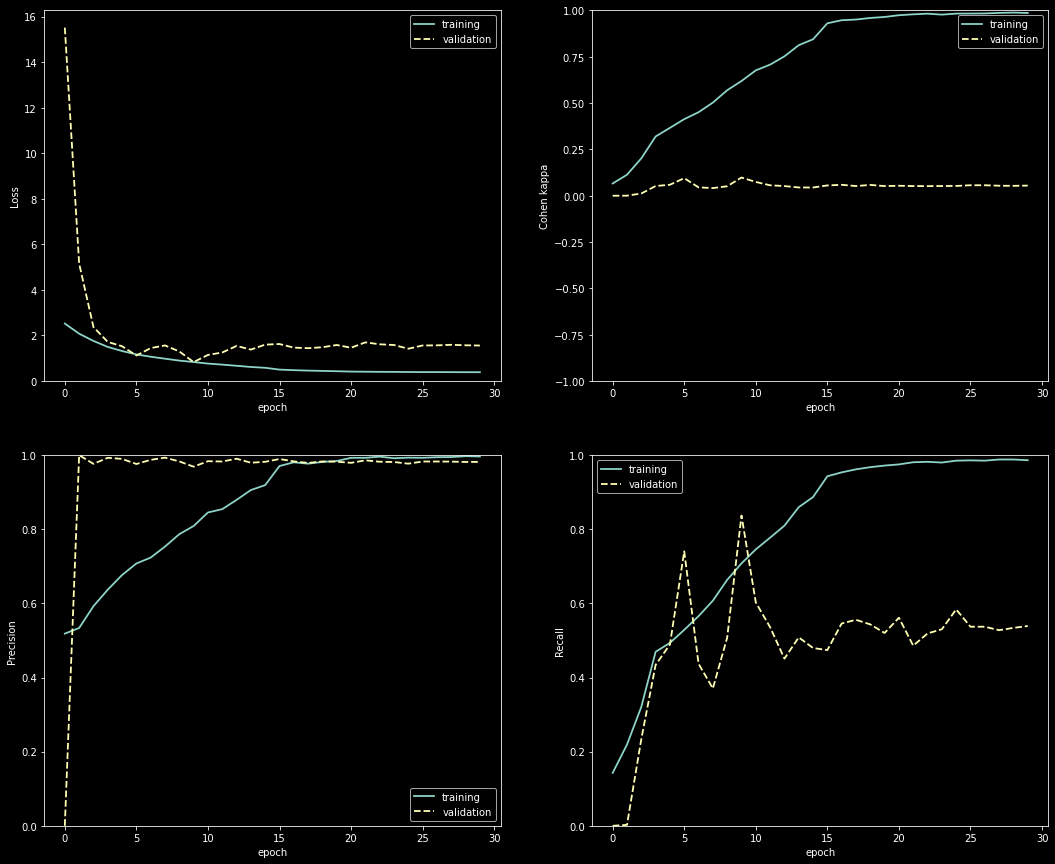

In [79]:
plot_metrics(history)

In [80]:
# get the loss value & metrics values for the model in test mode
evaluation_metrics = model.evaluate(testset, verbose=1)

18/18 [==============================] - 2s 105ms/step - loss: 1.1991 - tp: 144.0000 - fp: 68.0000 - tn: 217.0000 - fn: 134.0000 - binary_acc: 0.6412 - precision: 0.6792 - recall: 0.5180 - f1_score: 0.5878 - roc_auc: 0.7119 - pr_auc: 0.7362 - cohen_kappa: 0.2802


In [81]:
loss = evaluation_metrics.pop(0)

print(f"test loss   : {loss}")
for metric, score in zip(METRICS, evaluation_metrics):

    print(f"{metric.name + ' ' * (12 - len(metric.name))}: {score}")

test loss   : 1.199089527130127
tp          : 144.0
fp          : 68.0
tn          : 217.0
fn          : 134.0
binary_acc  : 0.6412078142166138
precision   : 0.6792452931404114
recall      : 0.5179855823516846
f1_score    : 0.5877551436424255
roc_auc     : 0.7119209170341492
pr_auc      : 0.7362457513809204
cohen_kappa : 0.2802060842514038


In [82]:
# get predictions for the test dataset
preds = model.predict(testset, verbose=1)

18/18 [==============================] - 2s 95ms/step


In [83]:
temp_testset = ref_testset[ref_testset["study_type"] == "XR_SHOULDER"].copy()

temp_testset["label"] = temp_testset["label"].map(int)

In [84]:
cohen_kappa_score(
    temp_testset["label"].values,
    np.vectorize(lambda x: 1 if x > 0.5 else 0)(preds.ravel()),
)

0.28020607855795654

In [85]:
temp_testset["prediction"] = preds.ravel()

In [86]:
temp_testset = pd.DataFrame(
    [*study_oriented_transformation(temp_testset)],
    columns=["study", "label", "prediction"],
)

In [87]:
cohen_kappa_score(temp_testset["label"].values, temp_testset["prediction"].values)

0.38666809559532744

In [88]:
# model naming convention: {architecture}-{study-type}-{num-parameters}.h5
#
# to load model:
# model = tf.keras.models.load_model(
#     '../models/cnn-XR_SHOULDER-3305473.h5',
#     custom_objects={'F1Score': F1Score}
# )
model.save("../models/cnn-XR_SHOULDER-3305473.h5")

In [89]:
clean_up(model)
del temp_testset